# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera
### Kunal Shah


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal apartment for a rent near University of Illinois at Chicago (UIC). Specifically, this report will be targeted to people or students who intend to study at UIC and are interested in renting an apartment in **Chicago**, near University of Illinois at Chicago.

Since there are lots of apartments in Chicago we will try to locate **apartments near UIC (within 5 km radius) with favourable venues in the neighborhood for students**. We are also particularly interested in **apartments with 2 bedrooms and rent per month less than equal to 800-900$ per person**. We would also prefer locations **as close to UIC as possible** with good subway connectivity.

We will use our data science powers to generate a few most promissing neighborhoods and apartments based on this criteria. 

## Data <a name="data"></a>

Based on definition of our problem, data required to make our decission is:
* apartments availble for rent near UIC with geo location for plotting on map.
* the neighborhood of each apartment.
* the neighborhoods are scrapped from the Apartments dataframe.
* venues in each neighborhood.
* subway station locations with geo location for plotting on map.


Following data sources will be needed to extract/generate the required information:
* the apartments for rent were scrapped from the website: https://www.apartments.com/off-campus-housing/il/chicago/university-of-illinois-at-chicago/student-housing/
* the geo location of the apartments and their neighborhood was found using **Google Maps Geocoding API**
* the subway stations data with geo location was downloaded from the website: https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops/8pix-ypme/data

### Upload Libraries Required

In [1]:
from bs4 import BeautifulSoup as bs
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from bs4 import BeautifulSoup
from requests import get
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from googlemaps import Client as GoogleMaps

print('Libraries imported.')


Libraries imported.


## Apartments Data

###  Scrapping the apartments 

Scrapping the https://www.apartments.com/off-campus-housing/il/chicago/university-of-illinois-at-chicago/student-housing/ website for appartment listing near UIC using beautiful soup  

In [2]:
titles= []
address = []
prices = []
beds=[]

The apartment.com website was not allowing the python code to run while appending page number and it was redirecting the url to the first page so I had to individually scrape each page by changing the uic_url again and again.

In [3]:
headers = ({'User-Agent':'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
uic_url = 'https://www.apartments.com/off-campus-housing/il/chicago/university-of-illinois-at-chicago/student-housing/'
r=get(uic_url, headers=headers)
page_html = BeautifulSoup(r.text, 'html.parser')
house_containers = page_html.find_all('article')
if house_containers != []:
    for container in house_containers:
        price=container.find('div', class_="apartmentRentRollupContainer")
        if(price!=None):
            price=price.span.text
            sep = ' -'
            price=price.split(sep,1)[0]
            prices.append(price)
        else:
            price=''
            prices.append(price)

            # Address
        location = container.find('a',class_="placardTitle js-placardTitle")
        if(location!=None):
            location=location.get("title")
            address.append(location)        
        else:
            location=''
            address.append(location)

            # Title 
        name=container.find('a',class_="placardTitle js-placardTitle")
        if(name!=None):
            name=name.get("title")                
            titles.append(name)
        else:
            name=''
            titles.append(name)
            
            # Beds
        bed=container.find('div', class_="apartmentRentRollupContainer")
        if(bed!=None):
            bed=bed.find('span',class_="unitLabel").text
            beds.append(bed)
        else:
            bed=''
            beds.append(bed)
        
else:
    print("nothing found")
    
    
print('You scraped {} properties.'.format(len(titles)))


You scraped 26 properties.


In [4]:
cols = ['Title', 'Price', 'Address','Beds']

properties= pd.DataFrame({'Title': titles,
                           'Price': prices,
                           'Address':address,
                          'Beds': beds})[cols]
properties.head()


Title   Price                          Address  \
0                                     $858                                    
1  Landmark West Loop, Chicago, IL  $1,850  Landmark West Loop, Chicago, IL   
2       The Van Buren, Chicago, IL  $2,215       The Van Buren, Chicago, IL   
3              milieu, Chicago, IL  $1,977              milieu, Chicago, IL   
4          the Duncan, Chicago, IL  $1,146          the Duncan, Chicago, IL   

             Beds  
0         2-4 Bed  
1  Studio - 2 Bed  
2  Studio - 2 Bed  
3  Studio - 2 Bed  
4  Studio - 1 Bed

In [ ]:
frames = [properties, properties1, properties2,properties3, properties4,properties5,properties6,properties7, properties8,properties9,properties10,properties11,properties12,properties13,properties14,properties15,properties16,properties17,properties18,properties19,properties20,properties21,properties22,properties23,properties24,properties25,properties26]

In [ ]:
Chicago_rental= pd.concat(frames)

I did not execute the above code because I had to do it again for 28 pages. I saved my df to a csv file and uploaded the csv file here.

In [6]:
Chicago_rental=pd.read_csv("Chicago_rental.csv")

### Obtain geodata ( lat,long) and neighborhood for each rental place in Chicago with Google Maps Geocoding API 


### Appending neighborhood, latitude and longitude coloumm in our existing dataframe

In [8]:
Chicago_rental['Neighborhood'] = ''
Chicago_rental['Latitude'] = ''
Chicago_rental['Longitude'] = ''
Chicago_rental.head()

Title   Price  \
0                    Common Addams    $858   
1  Landmark West Loop, Chicago, IL  $1,850   
2       The Van Buren, Chicago, IL  $2,215   
3              milieu, Chicago, IL  $1,977   
4          the Duncan, Chicago, IL  $1,146   

                                  Address            Beds Neighborhood  \
0       1407 W 15th St, Chicago, IL 60608         2-4 Bed                
1  1035 W Van Buren St, Chicago, IL 60607  Studio - 2 Bed                
2   808 W Van Buren St, Chicago, IL 60607  Studio - 2 Bed                
3         205 S Peoria, Chicago, IL 60607  Studio - 2 Bed                
4     1515 W Monroe St, Chicago, IL 60607  Studio - 1 Bed                

  Latitude Longitude  
0                     
1                     
2                     
3                     
4

###  Enter google map api key for geocoding. I have not entered the API key for security reasons

In [10]:
gmaps = GoogleMaps('Enter Google API key')

In [11]:
for i, row in Chicago_rental.iterrows():
    location = gmaps.geocode(Chicago_rental.at[i,'Address'])
    if (len(location) == 0):
        Chicago_rental.at[i,'Neighborhood']=''
        Chicago_rental.at[i,'Latitude']=''
        Chicago_rental.at[i,'Longitude']=''
    else:
        for d in location[0]['address_components']:
            if(d['types'][0]=='neighborhood'):
                add=d['long_name']
        Chicago_rental.at[i,'Neighborhood']=add
        Chicago_rental.at[i,'Latitude']=location[0]['geometry']['location'] ['lat']
        Chicago_rental.at[i,'Longitude']=location[0]['geometry']['location'] ['lng']

Chicago_rental.head()

Title   Price  \
0                    Common Addams    $858   
1  Landmark West Loop, Chicago, IL  $1,850   
2       The Van Buren, Chicago, IL  $2,215   
3              milieu, Chicago, IL  $1,977   
4          the Duncan, Chicago, IL  $1,146   

                                  Address            Beds  Neighborhood  \
0       1407 W 15th St, Chicago, IL 60608         2-4 Bed  Little Italy   
1  1035 W Van Buren St, Chicago, IL 60607  Studio - 2 Bed     West Loop   
2   808 W Van Buren St, Chicago, IL 60607  Studio - 2 Bed     West Loop   
3         205 S Peoria, Chicago, IL 60607  Studio - 2 Bed     West Loop   
4     1515 W Monroe St, Chicago, IL 60607  Studio - 1 Bed     West Loop   

  Latitude Longitude  
0  41.8615  -87.6618  
1  41.8763  -87.6542  
2  41.8769  -87.6475  
3   41.879  -87.6494  
4  41.8798  -87.6654

## Finding distance from UIC from each apartment using Google Maps Distance Matrix API

In [50]:
Chicago_rental['Distance from UIC'] = ''
Chicago_rental.head()

Title   Price  \
0                    Common Addams   858.0   
1  Landmark West Loop, Chicago, IL  1850.0   
2       The Van Buren, Chicago, IL  2215.0   
3              milieu, Chicago, IL  1977.0   
4          the Duncan, Chicago, IL  1146.0   

                                  Address            Beds  Neighborhood  \
0       1407 W 15th St, Chicago, IL 60608         2-4 Bed  Little Italy   
1  1035 W Van Buren St, Chicago, IL 60607  Studio - 2 Bed     West Loop   
2   808 W Van Buren St, Chicago, IL 60607  Studio - 2 Bed     West Loop   
3         205 S Peoria, Chicago, IL 60607  Studio - 2 Bed     West Loop   
4     1515 W Monroe St, Chicago, IL 60607  Studio - 1 Bed     West Loop   

    Latitude  Longitude Distance from UIC  
0  41.861494 -87.661816                    
1  41.876311 -87.654182                    
2  41.876896 -87.647523                    
3  41.878992 -87.649431                    
4  41.879794 -87.665430

In [207]:
api_key='####'

url ='https://maps.googleapis.com/maps/api/distancematrix/json?'
dest='University of Illinois at Chicago'

In [52]:
for i, row in Chicago_rental.iterrows():
    r = requests.get(url + 'origins=' + Chicago_rental.at[i,'Address'] + '&destinations=' + dest + '&key=' + api_key)

    x = r.json()
    if(len(x["rows"])!=0):
        Chicago_rental.at[i,'Distance from UIC']=x["rows"][0].get("elements")[0].get("distance").get("value")/1000
    else:
        Chicago_rental.at[i,'Distance from UIC']=""
Chicago_rental.head()

Title   Price  \
0                    Common Addams   858.0   
1  Landmark West Loop, Chicago, IL  1850.0   
2       The Van Buren, Chicago, IL  2215.0   
3              milieu, Chicago, IL  1977.0   
4          the Duncan, Chicago, IL  1146.0   

                                  Address            Beds  Neighborhood  \
0       1407 W 15th St, Chicago, IL 60608         2-4 Bed  Little Italy   
1  1035 W Van Buren St, Chicago, IL 60607  Studio - 2 Bed     West Loop   
2   808 W Van Buren St, Chicago, IL 60607  Studio - 2 Bed     West Loop   
3         205 S Peoria, Chicago, IL 60607  Studio - 2 Bed     West Loop   
4     1515 W Monroe St, Chicago, IL 60607  Studio - 1 Bed     West Loop   

    Latitude  Longitude Distance from UIC  
0  41.861494 -87.661816             1.242  
1  41.876311 -87.654182             0.527  
2  41.876896 -87.647523              0.32  
3  41.878992 -87.649431             0.749  
4  41.879794 -87.665430             1.388

In [53]:
Chicago_rental

Title    Price  \
0                                        Common Addams    858.0   
1                      Landmark West Loop, Chicago, IL   1850.0   
2                           The Van Buren, Chicago, IL   2215.0   
3                                  milieu, Chicago, IL   1977.0   
4                              the Duncan, Chicago, IL   1146.0   
5                     JeffJack Apartments, Chicago, IL   1589.0   
6                       Gateway West Loop, Chicago, IL   1711.0   
7                              Union West, Chicago, IL   1428.0   
8                        727 West Madison, Chicago, IL   1835.0   
9                     Presidential Towers, Chicago, IL   1370.0   
10               The Parker Fulton Market, Chicago, IL   1804.0   
11                             The Cooper, Chicago, IL   1600.0   
12                     Alta Grand Central, Chicago, IL   1607.0   
13                         Alta Roosevelt, Chicago, IL   1721.0   
14                           Emme Chicago, Chicago, IL   1822.0   
15                            330 S Wells, Chicago, IL   1625.0   
16                             AMLI Lofts, Chicago, IL   1727.0   
17                         Burnham Pointe, Chicago, IL   1974.0   
18                                Imprint, Chicago, IL   1600.0   
19                          K2 Apartments, Chicago, IL   1699.0   
20                              731 South, Chicago, IL   1649.0   
21                  Millennium on LaSalle, Chicago, IL   1660.0   
22        Fisher Building City Apartments, Chicago, IL   1600.0   
23                       1001 South State, Chicago, IL   1700.0   
24                        777 South State, Chicago, IL   1575.0   
25                      Alta at K Station, Chicago, IL   1427.0   
26                        Wolf Point West, Chicago, IL   1811.0   
27                               Eleven40, Chicago, IL   1585.0   
28                       Linea Apartments, Chicago, IL   1969.0   
29                          Century Tower, Chicago, IL   1560.0   
30                              820 South, Chicago, IL   1449.0   
31                      Essex on the Park, Chicago, IL   1810.0   
32                          ELEVEN THIRTY, Chicago, IL   1306.0   
33                                 Coeval, Chicago, IL   1525.0   
34                            The Paragon, Chicago, IL   1870.0   
35                           NEMA Chicago, Chicago, IL   1921.0   
36                       1407 On Michigan, Chicago, IL   1600.0   
37                    Marquee at Block 37, Chicago, IL   1677.0   
38                                  Spoke, Chicago, IL   1775.0   
39                            EnV Chicago, Chicago, IL   1710.0   
40                            Hubbard 221, Chicago, IL   1725.0   
41            River North Park Apartments, Chicago, IL   1500.0   
42   Oakwood Residence Chicago River North, Chicago...   2000.0   
43               MDA City Club Apartments, Chicago, IL   1600.0   
44                       AMLI River North, Chicago, IL   1831.0   
45                           73 East Lake, Chicago, IL   2105.0   
46                                   MILA, Chicago, IL   1651.0   
47                                Marlowe, Chicago, IL   1812.0   
48                            GRAND PLAZA, Chicago, IL   1810.0   
49                 Aqua at Lakeshore East, Chicago, IL   1686.0   
50                     One Superior Place, Chicago, IL   1579.0   
51                Coast at Lakeshore East, Chicago, IL   1565.0   
52            The Tides at Lakeshore East, Chicago, IL   1472.0   
53                               Aurelien, Chicago, IL   2174.0   
54                       Optima Signature, Chicago, IL   2105.0   
55         The Shoreham at Lakeshore East, Chicago, IL   1447.0   
56                 North Water Apartments, Chicago, IL   1966.0   
57                                 Xavier, Chicago, IL   1910.0   
58                        Cityfront Place, Chicago, IL   1330.0   
59                         Ch

### Finding no of unique neighborhoods in Chicago_rental

In [13]:
unique_value = Chicago_rental["Neighborhood"].nunique()
unique_value

30

### Cleaning the price coloumn so that it can be converted to float for analysis

In [ ]:
for i, row in Chicago_rental.iterrows():
    Chicago_rental.at[i,'Price'] = Chicago_rental.at[i,'Price'].replace(',','')
    Chicago_rental.at[i,'Price'] = Chicago_rental.at[i,'Price'].replace('$','')

In [15]:
Chicago_rental= Chicago_rental[~Chicago_rental['Price'].isin(['Call for Rent'])]

In [16]:
Chicago_rental.reset_index(inplace=True,drop=True)
Chicago_rental.shape

(666, 7)

So, our chicago_rental has 666 rows.

### Cleaning the bed coloumn so that it can be used to calculate price per bedroom

In [171]:
sep = '-'
for i, row in Chicago_rental.iterrows():
    Chicago_rental.at[i,'Beds'] = Chicago_rental.at[i,'Beds'].split(sep, 1)[0]
Chicago_rental

Title    Price  \
0                                        Common Addams    858.0   
1                      Landmark West Loop, Chicago, IL   1850.0   
2                           The Van Buren, Chicago, IL   2215.0   
3                                  milieu, Chicago, IL   1977.0   
4                              the Duncan, Chicago, IL   1146.0   
5                     JeffJack Apartments, Chicago, IL   1589.0   
6                       Gateway West Loop, Chicago, IL   1711.0   
7                              Union West, Chicago, IL   1428.0   
8                        727 West Madison, Chicago, IL   1835.0   
9                     Presidential Towers, Chicago, IL   1370.0   
10               The Parker Fulton Market, Chicago, IL   1804.0   
11                             The Cooper, Chicago, IL   1600.0   
12                     Alta Grand Central, Chicago, IL   1607.0   
13                         Alta Roosevelt, Chicago, IL   1721.0   
14                           Emme Chicago, Chicago, IL   1822.0   
15                            330 S Wells, Chicago, IL   1625.0   
16                             AMLI Lofts, Chicago, IL   1727.0   
17                         Burnham Pointe, Chicago, IL   1974.0   
18                                Imprint, Chicago, IL   1600.0   
19                          K2 Apartments, Chicago, IL   1699.0   
20                              731 South, Chicago, IL   1649.0   
21                  Millennium on LaSalle, Chicago, IL   1660.0   
22        Fisher Building City Apartments, Chicago, IL   1600.0   
23                       1001 South State, Chicago, IL   1700.0   
24                        777 South State, Chicago, IL   1575.0   
25                      Alta at K Station, Chicago, IL   1427.0   
26                        Wolf Point West, Chicago, IL   1811.0   
27                               Eleven40, Chicago, IL   1585.0   
28                       Linea Apartments, Chicago, IL   1969.0   
29                          Century Tower, Chicago, IL   1560.0   
30                              820 South, Chicago, IL   1449.0   
31                      Essex on the Park, Chicago, IL   1810.0   
32                          ELEVEN THIRTY, Chicago, IL   1306.0   
33                                 Coeval, Chicago, IL   1525.0   
34                            The Paragon, Chicago, IL   1870.0   
35                           NEMA Chicago, Chicago, IL   1921.0   
36                       1407 On Michigan, Chicago, IL   1600.0   
37                    Marquee at Block 37, Chicago, IL   1677.0   
38                                  Spoke, Chicago, IL   1775.0   
39                            EnV Chicago, Chicago, IL   1710.0   
40                            Hubbard 221, Chicago, IL   1725.0   
41            River North Park Apartments, Chicago, IL   1500.0   
42   Oakwood Residence Chicago River North, Chicago...   2000.0   
43               MDA City Club Apartments, Chicago, IL   1600.0   
44                       AMLI River North, Chicago, IL   1831.0   
45                           73 East Lake, Chicago, IL   2105.0   
46                                   MILA, Chicago, IL   1651.0   
47                                Marlowe, Chicago, IL   1812.0   
48                            GRAND PLAZA, Chicago, IL   1810.0   
49                 Aqua at Lakeshore East, Chicago, IL   1686.0   
50                     One Superior Place, Chicago, IL   1579.0   
51                Coast at Lakeshore East, Chicago, IL   1565.0   
52            The Tides at Lakeshore East, Chicago, IL   1472.0   
53                               Aurelien, Chicago, IL   2174.0   
54                       Optima Signature, Chicago, IL   2105.0   
55         The Shoreham at Lakeshore East, Chicago, IL   1447.0   
56                 North Water Apartments, Chicago, IL   1966.0   
57                                 Xavier, Chicago, IL   1910.0   
58                        Cityfront Place, Chicago, IL   1330.0   
59                         Ch

In [174]:
Chicago_rental['Beds'].replace('Studio','1',inplace=True)
Chicago_rental['Beds'].replace('Studio ','1',inplace=True)
Chicago_rental['Beds'].replace('Condo for Rent','2',inplace=True)
Chicago_rental['Beds'].replace('House for Rent','3',inplace=True)
Chicago_rental['Beds'].replace('Townhome for Rent','5',inplace=True)
Chicago_rental

Title    Price  \
0                                        Common Addams    858.0   
1                      Landmark West Loop, Chicago, IL   1850.0   
2                           The Van Buren, Chicago, IL   2215.0   
3                                  milieu, Chicago, IL   1977.0   
4                              the Duncan, Chicago, IL   1146.0   
5                     JeffJack Apartments, Chicago, IL   1589.0   
6                       Gateway West Loop, Chicago, IL   1711.0   
7                              Union West, Chicago, IL   1428.0   
8                        727 West Madison, Chicago, IL   1835.0   
9                     Presidential Towers, Chicago, IL   1370.0   
10               The Parker Fulton Market, Chicago, IL   1804.0   
11                             The Cooper, Chicago, IL   1600.0   
12                     Alta Grand Central, Chicago, IL   1607.0   
13                         Alta Roosevelt, Chicago, IL   1721.0   
14                           Emme Chicago, Chicago, IL   1822.0   
15                            330 S Wells, Chicago, IL   1625.0   
16                             AMLI Lofts, Chicago, IL   1727.0   
17                         Burnham Pointe, Chicago, IL   1974.0   
18                                Imprint, Chicago, IL   1600.0   
19                          K2 Apartments, Chicago, IL   1699.0   
20                              731 South, Chicago, IL   1649.0   
21                  Millennium on LaSalle, Chicago, IL   1660.0   
22        Fisher Building City Apartments, Chicago, IL   1600.0   
23                       1001 South State, Chicago, IL   1700.0   
24                        777 South State, Chicago, IL   1575.0   
25                      Alta at K Station, Chicago, IL   1427.0   
26                        Wolf Point West, Chicago, IL   1811.0   
27                               Eleven40, Chicago, IL   1585.0   
28                       Linea Apartments, Chicago, IL   1969.0   
29                          Century Tower, Chicago, IL   1560.0   
30                              820 South, Chicago, IL   1449.0   
31                      Essex on the Park, Chicago, IL   1810.0   
32                          ELEVEN THIRTY, Chicago, IL   1306.0   
33                                 Coeval, Chicago, IL   1525.0   
34                            The Paragon, Chicago, IL   1870.0   
35                           NEMA Chicago, Chicago, IL   1921.0   
36                       1407 On Michigan, Chicago, IL   1600.0   
37                    Marquee at Block 37, Chicago, IL   1677.0   
38                                  Spoke, Chicago, IL   1775.0   
39                            EnV Chicago, Chicago, IL   1710.0   
40                            Hubbard 221, Chicago, IL   1725.0   
41            River North Park Apartments, Chicago, IL   1500.0   
42   Oakwood Residence Chicago River North, Chicago...   2000.0   
43               MDA City Club Apartments, Chicago, IL   1600.0   
44                       AMLI River North, Chicago, IL   1831.0   
45                           73 East Lake, Chicago, IL   2105.0   
46                                   MILA, Chicago, IL   1651.0   
47                                Marlowe, Chicago, IL   1812.0   
48                            GRAND PLAZA, Chicago, IL   1810.0   
49                 Aqua at Lakeshore East, Chicago, IL   1686.0   
50                     One Superior Place, Chicago, IL   1579.0   
51                Coast at Lakeshore East, Chicago, IL   1565.0   
52            The Tides at Lakeshore East, Chicago, IL   1472.0   
53                               Aurelien, Chicago, IL   2174.0   
54                       Optima Signature, Chicago, IL   2105.0   
55         The Shoreham at Lakeshore East, Chicago, IL   1447.0   
56                 North Water Apartments, Chicago, IL   1966.0   
57                                 Xavier, Chicago, IL   1910.0   
58                        Cityfront Place, Chicago, IL   1330.0   
59                         Ch

In [175]:
sep = ' '
for i, row in Chicago_rental.iterrows():
    Chicago_rental.at[i,'Beds'] = Chicago_rental.at[i,'Beds'].split(sep, 1)[0]
Chicago_rental

Title    Price  \
0                                        Common Addams    858.0   
1                      Landmark West Loop, Chicago, IL   1850.0   
2                           The Van Buren, Chicago, IL   2215.0   
3                                  milieu, Chicago, IL   1977.0   
4                              the Duncan, Chicago, IL   1146.0   
5                     JeffJack Apartments, Chicago, IL   1589.0   
6                       Gateway West Loop, Chicago, IL   1711.0   
7                              Union West, Chicago, IL   1428.0   
8                        727 West Madison, Chicago, IL   1835.0   
9                     Presidential Towers, Chicago, IL   1370.0   
10               The Parker Fulton Market, Chicago, IL   1804.0   
11                             The Cooper, Chicago, IL   1600.0   
12                     Alta Grand Central, Chicago, IL   1607.0   
13                         Alta Roosevelt, Chicago, IL   1721.0   
14                           Emme Chicago, Chicago, IL   1822.0   
15                            330 S Wells, Chicago, IL   1625.0   
16                             AMLI Lofts, Chicago, IL   1727.0   
17                         Burnham Pointe, Chicago, IL   1974.0   
18                                Imprint, Chicago, IL   1600.0   
19                          K2 Apartments, Chicago, IL   1699.0   
20                              731 South, Chicago, IL   1649.0   
21                  Millennium on LaSalle, Chicago, IL   1660.0   
22        Fisher Building City Apartments, Chicago, IL   1600.0   
23                       1001 South State, Chicago, IL   1700.0   
24                        777 South State, Chicago, IL   1575.0   
25                      Alta at K Station, Chicago, IL   1427.0   
26                        Wolf Point West, Chicago, IL   1811.0   
27                               Eleven40, Chicago, IL   1585.0   
28                       Linea Apartments, Chicago, IL   1969.0   
29                          Century Tower, Chicago, IL   1560.0   
30                              820 South, Chicago, IL   1449.0   
31                      Essex on the Park, Chicago, IL   1810.0   
32                          ELEVEN THIRTY, Chicago, IL   1306.0   
33                                 Coeval, Chicago, IL   1525.0   
34                            The Paragon, Chicago, IL   1870.0   
35                           NEMA Chicago, Chicago, IL   1921.0   
36                       1407 On Michigan, Chicago, IL   1600.0   
37                    Marquee at Block 37, Chicago, IL   1677.0   
38                                  Spoke, Chicago, IL   1775.0   
39                            EnV Chicago, Chicago, IL   1710.0   
40                            Hubbard 221, Chicago, IL   1725.0   
41            River North Park Apartments, Chicago, IL   1500.0   
42   Oakwood Residence Chicago River North, Chicago...   2000.0   
43               MDA City Club Apartments, Chicago, IL   1600.0   
44                       AMLI River North, Chicago, IL   1831.0   
45                           73 East Lake, Chicago, IL   2105.0   
46                                   MILA, Chicago, IL   1651.0   
47                                Marlowe, Chicago, IL   1812.0   
48                            GRAND PLAZA, Chicago, IL   1810.0   
49                 Aqua at Lakeshore East, Chicago, IL   1686.0   
50                     One Superior Place, Chicago, IL   1579.0   
51                Coast at Lakeshore East, Chicago, IL   1565.0   
52            The Tides at Lakeshore East, Chicago, IL   1472.0   
53                               Aurelien, Chicago, IL   2174.0   
54                       Optima Signature, Chicago, IL   2105.0   
55         The Shoreham at Lakeshore East, Chicago, IL   1447.0   
56                 North Water Apartments, Chicago, IL   1966.0   
57                                 Xavier, Chicago, IL   1910.0   
58                        Cityfront Place, Chicago, IL   1330.0   
59                         Ch

### Converting the price, latitude, longitude,beds coloumns of chicago_rental into float for analysis and plotting

In [176]:
convert_dict = {'Price': float,
               'Latitude': float,
               'Longitude': float,
               'Distance from UIC': float,
               'Beds': float} 
Chicago_rental = Chicago_rental.astype(convert_dict) 
print(Chicago_rental.dtypes) 

Title                 object
Price                float64
Address               object
Beds                 float64
Neighborhood          object
Latitude             float64
Longitude            float64
Distance from UIC    float64
dtype: object


#### Adding the price per bedroom coloumn which is price/beds

In [177]:
Chicago_rental['Price per bed'] = ''
for i, row in Chicago_rental.iterrows():
    Chicago_rental.at[i,'Price per bed']=Chicago_rental.at[i,'Price']/Chicago_rental.at[i,'Beds']
    

Chicago_rental.head()

Title   Price  \
0                    Common Addams   858.0   
1  Landmark West Loop, Chicago, IL  1850.0   
2       The Van Buren, Chicago, IL  2215.0   
3              milieu, Chicago, IL  1977.0   
4          the Duncan, Chicago, IL  1146.0   

                                  Address  Beds  Neighborhood   Latitude  \
0       1407 W 15th St, Chicago, IL 60608   2.0  Little Italy  41.861494   
1  1035 W Van Buren St, Chicago, IL 60607   1.0     West Loop  41.876311   
2   808 W Van Buren St, Chicago, IL 60607   1.0     West Loop  41.876896   
3         205 S Peoria, Chicago, IL 60607   1.0     West Loop  41.878992   
4     1515 W Monroe St, Chicago, IL 60607   1.0     West Loop  41.879794   

   Longitude  Distance from UIC Price per bed  
0 -87.661816              1.242           429  
1 -87.654182              0.527          1850  
2 -87.647523              0.320          2215  
3 -87.649431              0.749          1977  
4 -87.665430              1.388          1146

## Neighborhoods Data

### Now, we will extract the neighborhoods from our apartment data and make a new dataframe for neighborhoods

In [23]:
neighborhoods=Chicago_rental.copy()

In [24]:
neighborhoods=neighborhoods.drop(columns=['Address','Title','Latitude','Longitude','Price','Beds'])
neighborhoods.head()

Neighborhood
0  Little Italy
1     West Loop
2     West Loop
3     West Loop
4     West Loop

In [25]:
neighborhoods.drop_duplicates(inplace=True, keep='first')
neighborhoods.reset_index(inplace=True,drop=True)
neighborhoods

Neighborhood
0      Little Italy
1         West Loop
2      Chicago Loop
3         West Town
4       River North
5   Near South Side
6   Rush & Division
7     Streeterville
8      Goose Island
9        Gold Coast
10  Near North Side
11    Fulton Market
12   Near West Side
13       Near North
14     Pulaski Park
15  Lower West Side
16       Tri-Taylor
17       Bridgeport
18   Heart of Italy
19  Marshall Square
20    Garfield Park
21      East Pilsen
22    Armour Square
23    Cabrini-Green
24   North Lawndale
25    Humboldt Park
26    South Commons
27    McKinley Park
28   South Lawndale
29     Lincoln Park

### Getting latitude and longitude for each neighborhood

In [26]:
neighborhoods['Latitude'] = ''
neighborhoods['Longitude'] = ''
neighborhoods.head()

Neighborhood Latitude Longitude
0  Little Italy                   
1     West Loop                   
2  Chicago Loop                   
3     West Town                   
4   River North

In [27]:
neighborhoods['Neighborhood'] =  neighborhoods['Neighborhood'].astype(str) + ', Chicago'
neighborhoods.head()

Neighborhood Latitude Longitude
0  Little Italy, Chicago                   
1     West Loop, Chicago                   
2  Chicago Loop, Chicago                   
3     West Town, Chicago                   
4   River North, Chicago

In [28]:
for i, row in neighborhoods.iterrows():
    location = gmaps.geocode(neighborhoods.at[i,'Neighborhood'])
    if (len(location) == 0):
        neighborhoods.at[i,'Latitude']=''
        neighborhoods.at[i,'Longitude']=''
    else:
        neighborhoods.at[i,'Latitude']=location[0]['geometry']['location'] ['lat']
        neighborhoods.at[i,'Longitude']=location[0]['geometry']['location'] ['lng']

neighborhoods.head()

Neighborhood Latitude Longitude
0  Little Italy, Chicago  41.8695  -87.6511
1     West Loop, Chicago  41.8854  -87.6627
2  Chicago Loop, Chicago  41.8786  -87.6251
3     West Town, Chicago  41.8936  -87.6722
4   River North, Chicago  41.8924  -87.6341

### Converting the data type latitude and longitude coloumn of neighborhoods data frame

In [30]:
convert_dict = {'Latitude': float,
               'Longitude': float} 
neighborhoods = neighborhoods.astype(convert_dict) 
print(neighborhoods.dtypes) 

Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object


## Subway stations in Chicago Data

The subway stations data was readily available on: https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops-Map/zbnc-zirh  and I downloded the csv file

In [32]:
Chicago_subway_stations=pd.read_csv('CTA_-_System_Information_-_List_of__L__Stops_-_Map.csv')
Chicago_subway_stations.head()

STOP_ID                        STOP_NAME          STATION_NAME  MAP_ID  \
0    30162         18th (54th/Cermak-bound)                  18th   40830   
1    30161                18th (Loop-bound)                  18th   40830   
2    30022         35th/Archer (Loop-bound)           35th/Archer   40120   
3    30023       35th/Archer (Midway-bound)           35th/Archer   40120   
4    30214  35-Bronzeville-IIT (63rd-bound)  35th-Bronzeville-IIT   41120   

    ADA    RED   BLUE      G    BRN      P   Pexp      Y    Pnk      O  \
0  True  False  False  False  False  False  False  False   True  False   
1  True  False  False  False  False  False  False  False   True  False   
2  True  False  False  False  False  False  False  False  False   True   
3  True  False  False  False  False  False  False  False  False   True   
4  True  False  False   True  False  False  False  False  False  False   

                  Location  
0  (41.857908, -87.669147)  
1  (41.857908, -87.669147)  
2  (41.829353, -87.680622)  
3  (41.829353, -87.680622)  
4  (41.831677, -87.625826)

### Cleaning the data and keeping only the features that we will require

In [33]:
Chicago_subway_stations=Chicago_subway_stations.drop(columns=['STOP_ID','STOP_NAME','MAP_ID','ADA','RED','BLUE','G','BRN','P','Pexp','Y','Pnk','O'])
Chicago_subway_stations.head()

STATION_NAME                 Location
0                  18th  (41.857908, -87.669147)
1                  18th  (41.857908, -87.669147)
2           35th/Archer  (41.829353, -87.680622)
3           35th/Archer  (41.829353, -87.680622)
4  35th-Bronzeville-IIT  (41.831677, -87.625826)

In [34]:
Chicago_subway_stations.drop_duplicates(inplace=True)
Chicago_subway_stations.reset_index(inplace=True,drop=True)
Chicago_subway_stations.head()

STATION_NAME                 Location
0                  18th  (41.857908, -87.669147)
1           35th/Archer  (41.829353, -87.680622)
2  35th-Bronzeville-IIT  (41.831677, -87.625826)
3                  43rd  (41.816462, -87.619021)
4                  47th  (41.809209, -87.618826)

In [35]:
split_data = Chicago_subway_stations.Location.str.strip(')').str.strip('(').str.split(', ')
Chicago_subway_stations['Latitude'] = split_data.apply(lambda x: x[0])
Chicago_subway_stations['Longitude'] = split_data.apply(lambda x: x[1])
Chicago_subway_stations.head()

STATION_NAME                 Location   Latitude   Longitude
0                  18th  (41.857908, -87.669147)  41.857908  -87.669147
1           35th/Archer  (41.829353, -87.680622)  41.829353  -87.680622
2  35th-Bronzeville-IIT  (41.831677, -87.625826)  41.831677  -87.625826
3                  43rd  (41.816462, -87.619021)  41.816462  -87.619021
4                  47th  (41.809209, -87.618826)  41.809209  -87.618826

In [36]:
Chicago_subway_stations=Chicago_subway_stations.drop(columns=['Location'])
Chicago_subway_stations

STATION_NAME     Latitude     Longitude
0                                         18th    41.857908    -87.669147
1                                  35th/Archer    41.829353    -87.680622
2                         35th-Bronzeville-IIT    41.831677    -87.625826
3                                         43rd    41.816462    -87.619021
4                                         47th    41.809209    -87.618826
5                                         47th    41.810318     -87.63094
6                                         51st     41.80209    -87.618487
7                                  54th/Cermak  41.85177331  -87.75669201
8                                         63rd    41.780536    -87.630952
9                                         69th    41.768367    -87.625724
10                                        79th    41.750419    -87.625112
11                                        87th    41.735372    -87.624717
12                               95th/Dan Ryan    41.722377    -87.624342
13                               95th/Ran Ryan    41.722377    -87.624342
14                                Adams/Wabash    41.879507    -87.626037
15                                     Addison     41.94738     -87.71906
16                                     Addison    41.947028    -87.674642
17                                     Addison    41.947428    -87.653626
18                                      Argyle    41.973453     -87.65853
19                                    Armitage    41.918217    -87.652644
20                                     Ashland    41.885269    -87.666969
21                                     Ashland    41.839234    -87.665317
22                                Ashland/63rd     41.77886    -87.663766
23                                      Austin    41.870851    -87.776812
24                                      Austin    41.887293    -87.774135
25                                     Belmont    41.938132    -87.712359
26                                     Belmont    41.939751     -87.65338
27                                      Berwyn    41.977984    -87.658668
28                                   Bryn Mawr    41.983504     -87.65884
29                                  California    41.854109    -87.694774
30                                  California     41.88422    -87.696234
31                                  California    41.921939     -87.69689
32                                     Central    41.887389     -87.76565
33                                     Central    42.063987    -87.685617
34                                Central Park    41.853839    -87.714842
35                            Cermak-Chinatown    41.853206    -87.630968
36                      Cermak-McCormick Place    41.853115    -87.626402
37                                     Chicago    41.896075    -87.655214
38                                     Chicago     41.89681    -87.635924
39                                     Chicago    41.896671    -87.628176
40                                      Cicero     41.85182    -87.745336
41                                      Cicero    41.871574    -87.745154
42                                      Cicero    41.886519    -87.744698
43                              Clark/Division     41.90392    -87.631412
44                                  Clark/Lake    41.885737    -87.630886
45                                     Clinton    41.875539    -87.640984
46                                     Clinton    41.885678    -87.641782
47                                Conservatory    41.884904    -87.716523
48                               Cottage Grove    41.780309    -87.605857
49                                  Cumberland    41.984246    -87.838028
50                                       Damen    41.854517    -87.675975
51                                       Damen    41.909744    -87.677437
52                                       Damen    41.966286    -87.678639
53                                    

In [37]:
Chicago_subway_stations= Chicago_subway_stations.rename(columns={'STATION_NAME': 'Station Name'})
Chicago_subway_stations.head()

Station Name   Latitude   Longitude
0                  18th  41.857908  -87.669147
1           35th/Archer  41.829353  -87.680622
2  35th-Bronzeville-IIT  41.831677  -87.625826
3                  43rd  41.816462  -87.619021
4                  47th  41.809209  -87.618826

In [82]:
Chicago_subway_stations.dtypes

Station Name    object
Latitude        object
Longitude       object
dtype: object

In [83]:
convert_dict = {'Latitude': float,
               'Longitude': float} 
Chicago_subway_stations = Chicago_subway_stations.astype(convert_dict) 
print(Chicago_subway_stations.dtypes) 

Station Name     object
Latitude        float64
Longitude       float64
dtype: object


### Foursquare

Now, we have all the data that is required. We will now use Foursquare api to get the top 10 venues in each neighborhood.

In [40]:
CLIENT_ID = '####' # your Foursquare ID
CLIENT_SECRET = '####' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')


Your credentails:


## Explore Neighborhoods in Chicago

In [43]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 

In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=1600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [45]:
Chicago_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Little Italy, Chicago
West Loop, Chicago
Chicago Loop, Chicago
West Town, Chicago
River North, Chicago
Near South Side, Chicago
Rush & Division, Chicago
Streeterville, Chicago
Goose Island, Chicago
Gold Coast, Chicago
Near North Side, Chicago
Fulton Market, Chicago
Near West Side, Chicago
Near North, Chicago
Pulaski Park, Chicago
Lower West Side, Chicago
Tri-Taylor, Chicago
Bridgeport, Chicago
Heart of Italy, Chicago
Marshall Square, Chicago
Garfield Park, Chicago
East Pilsen, Chicago
Armour Square, Chicago
Cabrini-Green, Chicago
North Lawndale, Chicago
Humboldt Park, Chicago
South Commons, Chicago
McKinley Park, Chicago
South Lawndale, Chicago
Lincoln Park, Chicago


#### Let's check the size of the resulting dataframe

In [46]:
print(Chicago_venues.shape)
Chicago_venues.head()

(2783, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Little Italy, Chicago               41.86954              -87.651133   
1  Little Italy, Chicago               41.86954              -87.651133   
2  Little Italy, Chicago               41.86954              -87.651133   
3  Little Italy, Chicago               41.86954              -87.651133   
4  Little Italy, Chicago               41.86954              -87.651133   

                               Venue  Venue Latitude  Venue Longitude  \
0                            Tuscany       41.869631       -87.651807   
1           Mario's Italian Lemonade       41.869529       -87.653783   
2                     Fontano's Subs       41.871888       -87.653545   
3                  Al's Italian Beef       41.869365       -87.653964   
4  UIC - Student Recreation Facility       41.872566       -87.646604   

       Venue Category  
0  Italian Restaurant  
1        Dessert Shop  
2      Sandwich Place  
3      Sandwich Place  
4         College Gym

### Now we have all the data that is required to perform some analysis and plotting to make an informed decision

# Methodology <a name="methodology"></a>

In this project we will direct our efforts on locating apartments near UIC that fit our budget and our criteria.

In first step we have collected the required data: **Apartment listing with neighborhoods and geo location, neighborhoods and their geo data, subway stations data**. We have also gathered **venues in each neighborhood** (From Foursquare).

**Second step:** The strategy is based on mapping the above described data, in order to facilitate the choice of apartments from all the apartment listings. The choice is made based on the requirements established : location near a subway, rental price under 2000$. This visual approach and maps with popups labels allow quick identification of location, price and feature, thus making the selection very easy.

The procesing of these DATA and its mapping will allow to answer the key questions to make a decision:

* what is the cost of available rental places that meet the demands?
* what is the cost of rent around a mile radius from each subway metro station?
* what is the area of Chicago near UIC with best rental pricing that meets criteria established?
* What are the venues of the two best places to live? How the prices compare?


## Analysis <a name="analysis"></a>

### Let's perform some basic explanatory data analysis and derive some additional info from our raw data

### Chicago apartment rent price statistical analysis

###  Finding mean price of apartments in each neighborhood

In [19]:
Chicago_rental.groupby('Neighborhood')['Price'].mean()

Neighborhood
Armour Square      1518.750000
Bridgeport         1323.076923
Cabrini-Green      3210.666667
Chicago Loop       2044.797872
East Pilsen        3468.750000
Fulton Market      2232.000000
Garfield Park      1517.230769
Gold Coast         1641.666667
Goose Island       3196.545455
Heart of Italy     1525.000000
Humboldt Park      1395.000000
Lincoln Park       3300.000000
Little Italy       2148.000000
Lower West Side    1678.590909
Marshall Square    1442.368421
McKinley Park      1087.500000
Near North         2573.823529
Near North Side    2690.409091
Near South Side    2346.513514
Near West Side     1862.294118
North Lawndale     1215.000000
Pulaski Park       2341.583333
River North        2566.026667
Rush & Division    1717.866667
South Commons      1300.000000
South Lawndale     1325.000000
Streeterville      2741.741935
Tri-Taylor         2128.500000
West Loop          2301.513889
West Town          2460.122222
Name: Price, dtype: float64

### Finding mean rent of an apartment in Chicago

In [20]:
Chicago_rental['Price'].mean()

2261.171171171171

### So, the avg rent for an apartment in Chicago is around 2261 dollars which is somewhat closer to my requirement of 2000 dollars

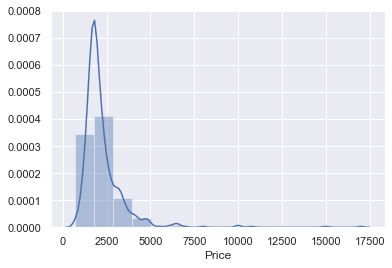

In [21]:
import seaborn as sns
sns.distplot(Chicago_rental['Price'],bins=15)

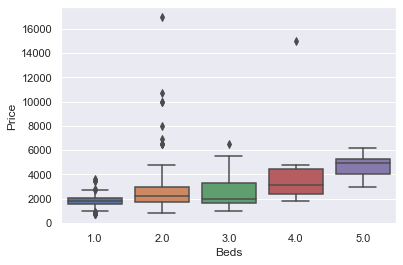

In [178]:
sns.boxplot(x='Beds', y= 'Price', data=Chicago_rental)

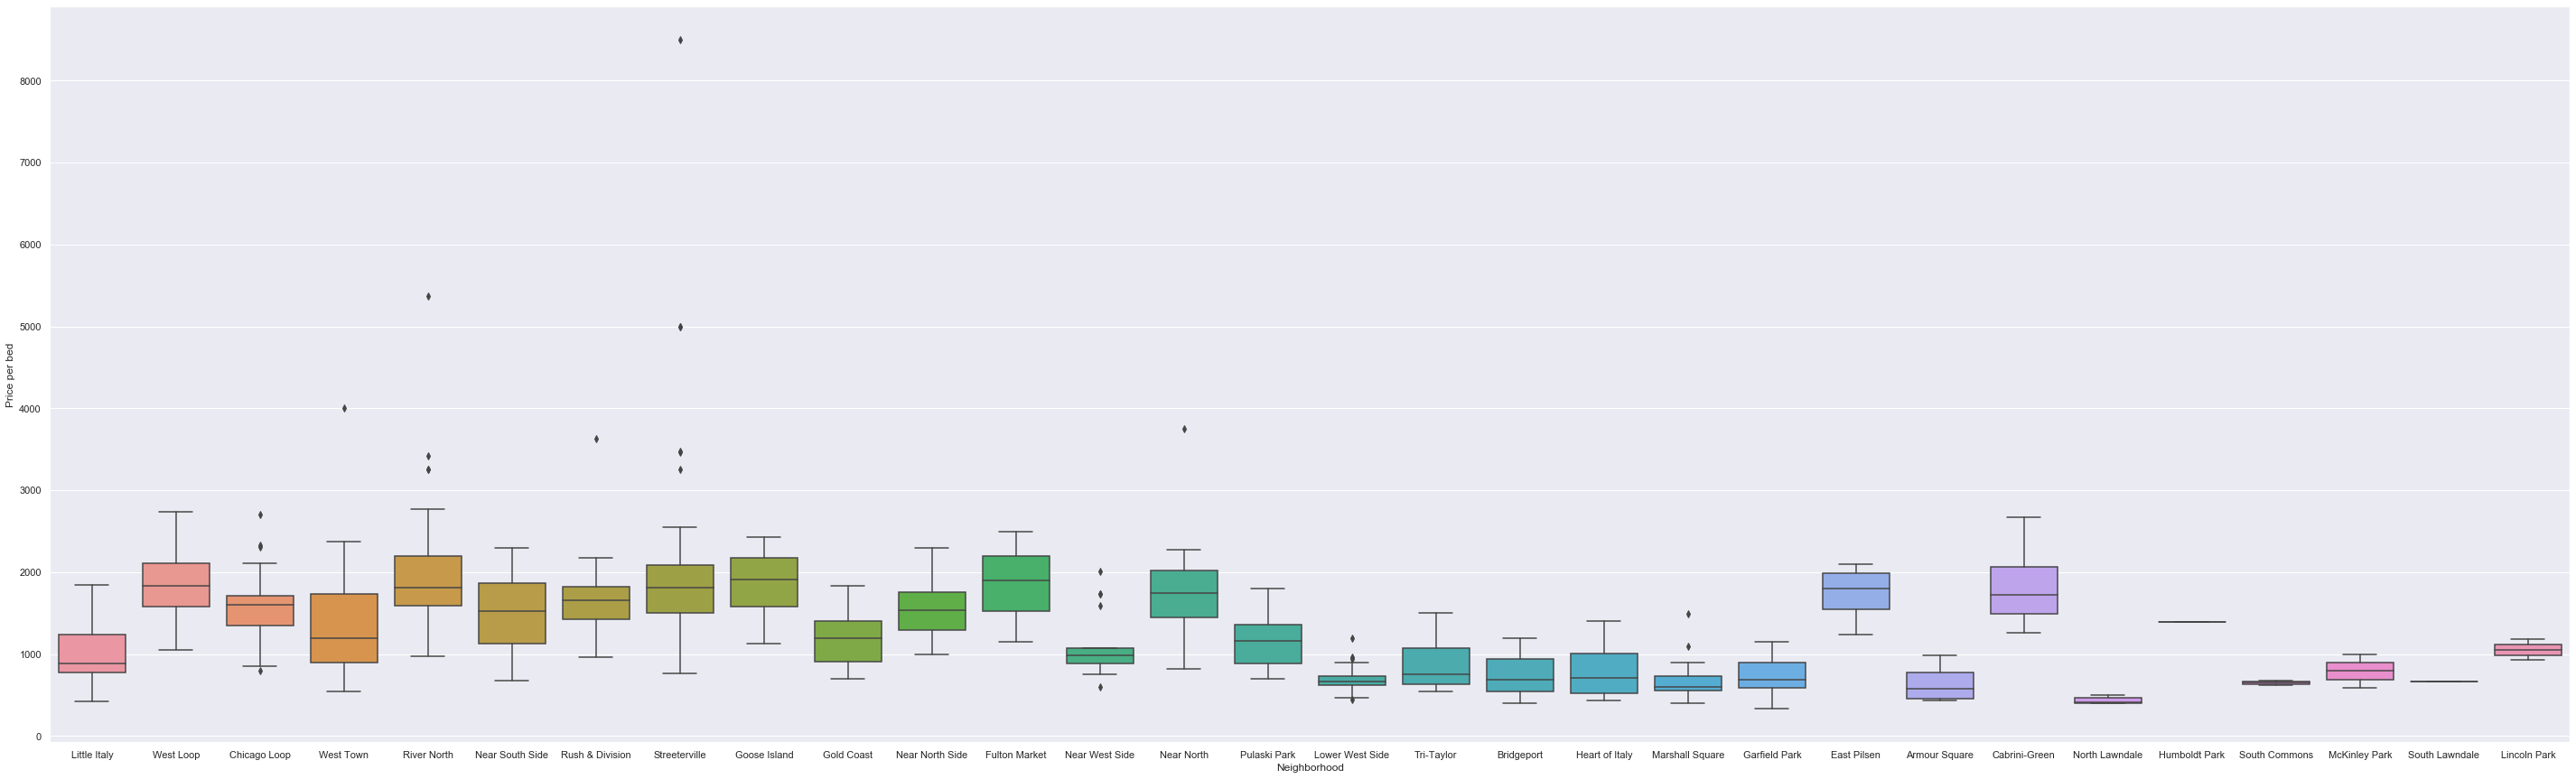

In [179]:
plt.figure(figsize=(50,15))
sns.boxplot(x='Neighborhood', y= 'Price per bed', data=Chicago_rental)
plt.show()

### Finding mean distance from UIC

In [85]:
Chicago_rental['Distance from UIC'].mean()

3.814474309309306

So, avg distance from apartment to UIC is 3.8 km which is nice because we will have a lot of option to select from

## Analysing neighborhood venues data

Let's check how many venues were returned for each neighborhood

In [87]:
Chicago_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                              
Armour Square, Chicago                      100                     100   
Bridgeport, Chicago                         100                     100   
Cabrini-Green, Chicago                      100                     100   
Chicago Loop, Chicago                       100                     100   
East Pilsen, Chicago                        100                     100   
Fulton Market, Chicago                      100                     100   
Garfield Park, Chicago                       53                      53   
Gold Coast, Chicago                         100                     100   
Goose Island, Chicago                       100                     100   
Heart of Italy, Chicago                      93                      93   
Humboldt Park, Chicago                       60                      60   
Lincoln Park, Chicago                       100                     100   
Little Italy, Chicago                       100                     100   
Lower West Side, Chicago                    100                     100   
Marshall Square, Chicago                     86                      86   
McKinley Park, Chicago                       86                      86   
Near North Side, Chicago                    100                     100   
Near North, Chicago                         100                     100   
Near South Side, Chicago                    100                     100   
Near West Side, Chicago                     100                     100   
North Lawndale, Chicago                      35                      35   
Pulaski Park, Chicago                       100                     100   
River North, Chicago                        100                     100   
Rush & Division, Chicago                    100                     100   
South Commons, Chicago                       95                      95   
South Lawndale, Chicago                      75                      75   
Streeterville, Chicago                      100                     100   
Tri-Taylor, Chicago                         100                     100   
West Loop, Chicago                          100                     100   
West Town, Chicago                          100                     100   

                          Venue  Venue Latitude  Venue Longitude  \
Neighborhood                                                       
Armour Square, Chicago      100             100              100   
Bridgeport, Chicago         100             100              100   
Cabrini-Green, Chicago      100             100              100   
Chicago Loop, Chicago       100             100              100   
East Pilsen, Chicago        100             100              100   
Fulton Market, Chicago      100             100              100   
Garfield Park, Chicago       53              53               53   
Gold Coast, Chicago         100             100              100   
Goose Island, Chicago       100             100              100   
Heart of Italy, Chicago      93              93               93   
Humboldt Park, Chicago       60              60               60   
Lincoln Park, Chicago       100             100              100   
Little Italy, Chicago       100             100              100   
Lower West Side, Chicago    100             100              100   
Marshall Square, Chicago     86              86               86   
McKinley Park, Chicago       86              86               86   
Near North Side, Chicago    100             100              100   
Near North, Chicago         100             100              100   
Near South Side, Chicago    100             100              100   
Near West Side, Chicago     100             100              100   
North Lawndale, Chicago      35              35               35   
Pulaski Park, Chicago       100             100              

#### Let's find out how many unique categories can be curated from all the returned venues

In [88]:
print('There are {} uniques categories.'.format(len(Chicago_venues['Venue Category'].unique())))

There are 263 uniques categories.


### Analysing Each Neighborhood

In [89]:
# one hot encoding
Chicago_onehot = pd.get_dummies(Chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Chicago_onehot['Neighborhood'] = Chicago_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Chicago_onehot.columns[-1]] + list(Chicago_onehot.columns[:-1])
Chicago_onehot = Chicago_onehot[fixed_columns]

Chicago_onehot.head()

Neighborhood  African Restaurant  American Restaurant  \
0  Little Italy, Chicago                   0                    0   
1  Little Italy, Chicago                   0                    0   
2  Little Italy, Chicago                   0                    0   
3  Little Italy, Chicago                   0                    0   
4  Little Italy, Chicago                   0                    0   

   Amphitheater  Animal Shelter  Aquarium  Argentinian Restaurant  \
0             0               0         0                       0   
1             0               0         0                       0   
2             0               0         0                       0   
3             0               0         0                       0   
4             0               0         0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            0           0                    0                     0   
1            0           0                    0                     0   
2            0           0                    0                     0   
3            0           0                    0                     0   
4            0           0                    0                     0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Automotive Shop  \
0                 0                   0            0                0   
1                 0                   0            0                0   
2                 0                   0            0                0   
3                 0                   0            0                0   
4                 0                   0            0                0   

   BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0          0           0       0     0    0               0                 0   
1          0           0       0     0    0               0                 0   
2          0           0       0     0    0               0                 0   
3          0           0       0     0    0               0                 0   
4          0           0       0     0    0               0                 0   

   Basketball Court  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0                 0                   0      0                0         0   
1                 0                   0      0                0         0   
2                 0                   0      0                0         0   
3                 0                   0      0                0         0   
4                 0                   0      0                0         0   

   Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  Bistro  \
0            0           0              0                         0       0   
1            0           0              0                         0       0   
2            0           0              0                         0       0   
3            0           0              0                         0       0   
4            0           0              0                         0       0   

   Boat or Ferry  Bookstore  Botanical Garden  Boutique  Bowling Alley  \
0              0          0                 0         0              0   
1              0          0                 0         0              0   
2              0          0                 0         0              0   
3              0          0                 0         0              0   
4              0          0                 0         0              0   

   Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  Bridge  \
0           0                     0               0        0       0   
1           0                     0               0        0       0   
2           0                     0               0        0       0   
3           0                     0               0        0       0   
4           0                     0               0        0       0   

 

And let's examine the new dataframe size.

In [90]:
Chicago_onehot.shape

(2783, 264)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [91]:
Chicago_grouped = Chicago_onehot.groupby('Neighborhood').mean().reset_index()
Chicago_grouped

Neighborhood  African Restaurant  American Restaurant  \
0     Armour Square, Chicago            0.000000             0.000000   
1        Bridgeport, Chicago            0.000000             0.010000   
2     Cabrini-Green, Chicago            0.000000             0.010000   
3      Chicago Loop, Chicago            0.000000             0.020000   
4       East Pilsen, Chicago            0.000000             0.000000   
5     Fulton Market, Chicago            0.000000             0.000000   
6     Garfield Park, Chicago            0.000000             0.000000   
7        Gold Coast, Chicago            0.000000             0.040000   
8      Goose Island, Chicago            0.000000             0.020000   
9    Heart of Italy, Chicago            0.000000             0.000000   
10    Humboldt Park, Chicago            0.000000             0.016667   
11     Lincoln Park, Chicago            0.000000             0.010000   
12     Little Italy, Chicago            0.000000             0.000000   
13  Lower West Side, Chicago            0.000000             0.000000   
14  Marshall Square, Chicago            0.000000             0.000000   
15    McKinley Park, Chicago            0.000000             0.011628   
16  Near North Side, Chicago            0.000000             0.050000   
17       Near North, Chicago            0.000000             0.050000   
18  Near South Side, Chicago            0.000000             0.010000   
19   Near West Side, Chicago            0.000000             0.000000   
20   North Lawndale, Chicago            0.000000             0.000000   
21     Pulaski Park, Chicago            0.000000             0.020000   
22      River North, Chicago            0.000000             0.030000   
23  Rush & Division, Chicago            0.000000             0.050000   
24    South Commons, Chicago            0.010526             0.000000   
25   South Lawndale, Chicago            0.000000             0.000000   
26    Streeterville, Chicago            0.000000             0.050000   
27       Tri-Taylor, Chicago            0.000000             0.000000   
28        West Loop, Chicago            0.000000             0.010000   
29        West Town, Chicago            0.000000             0.010000   

    Amphitheater  Animal Shelter  Aquarium  Argentinian Restaurant  \
0           0.00            0.00      0.00                    0.00   
1           0.00            0.00      0.00                    0.00   
2           0.00            0.00      0.00                    0.00   
3           0.01            0.00      0.00                    0.00   
4           0.00            0.00      0.00                    0.00   
5           0.00            0.00      0.00                    0.00   
6           0.00            0.00      0.00                    0.00   
7           0.00            0.00      0.00                    0.00   
8           0.00            0.00      0.00                    0.00   
9           0.00            0.00      0.00                    0.00   
10          0.00            0.00      0.00                    0.00   
11          0.00            0.00      0.00                    0.01   
12          0.00            0.00      0.00                    0.00   
13          0.00            0.00      0.00                    0.00   
14          0.00            0.00      0.00                    0.00   
15          0.00            0.00      0.00                    0.00   
16          0.00            0.00      0.00                    0.00   
17          0.00            0.00      0.00                    0.00   
18          0.00            0.00      0.04                    0.00   
19          0.00            0.00      0.00                    0.00   
20          0.00            0.00      0.00                    0.00   
21          0.00            0.00      0.00                    0.00   
22          0.00            0.01      0.00                    0.00   
23          0.00            0.00      0.00                    0.00   
24

#### Let's confirm the new size

In [92]:
Chicago_grouped.shape

(30, 264)

#### Let's print each neighborhood along with the top 5 most common venues

In [93]:
num_top_venues = 5

for hood in Chicago_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Chicago_grouped[Chicago_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Armour Square, Chicago----
                venue  freq
0  Chinese Restaurant  0.17
1                 Bar  0.06
2         Pizza Place  0.05
3              Bakery  0.04
4  Mexican Restaurant  0.04


----Bridgeport, Chicago----
                venue  freq
0                 Bar  0.07
1         Pizza Place  0.06
2  Mexican Restaurant  0.06
3       Hot Dog Joint  0.05
4      Sandwich Place  0.05


----Cabrini-Green, Chicago----
                venue  freq
0         Coffee Shop  0.06
1                 Gym  0.06
2               Hotel  0.05
3          Steakhouse  0.05
4  Italian Restaurant  0.04


----Chicago Loop, Chicago----
          venue  freq
0         Hotel  0.10
1          Park  0.05
2  Burger Joint  0.03
3   Pizza Place  0.03
4   Coffee Shop  0.03


----East Pilsen, Chicago----
                   venue  freq
0     Chinese Restaurant  0.11
1                   Park  0.04
2          Hot Dog Joint  0.03
3       Asian Restaurant  0.03
4  Vietnamese Restaurant  0.03


----Fulton Market, 

#### Let's put that into a *pandas* dataframe

First, let's sort the venues in descending order.

In [95]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 20 venues for each neighborhood.

In [96]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Chicago_grouped['Neighborhood']

for ind in np.arange(Chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Armour Square, Chicago    Chinese Restaurant                   Bar   
1     Bridgeport, Chicago                   Bar           Pizza Place   
2  Cabrini-Green, Chicago           Coffee Shop                   Gym   
3   Chicago Loop, Chicago                 Hotel                  Park   
4    East Pilsen, Chicago    Chinese Restaurant                  Park   

  3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0           Pizza Place                 Bakery    Mexican Restaurant   
1    Mexican Restaurant          Hot Dog Joint           Art Gallery   
2            Steakhouse                  Hotel  Gym / Fitness Center   
3           Pizza Place           Burger Joint            Steakhouse   
4           Yoga Studio  Vietnamese Restaurant      Asian Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0         Hot Dog Joint        Sandwich Place           Coffee Shop   
1        Sandwich Place    Chinese Restaurant         Grocery Store   
2    Italian Restaurant                  Café         Grocery Store   
3           Coffee Shop               Theater    Italian Restaurant   
4                   Bar          Dessert Shop         Grocery Store   

  9th Most Common Venue 10th Most Common Venue         11th Most Common Venue  \
0     Korean Restaurant                   Park                    Wings Joint   
1                Bakery             Food Truck                         Lounge   
2           Pizza Place           Burger Joint                     Restaurant   
3           Music Venue                    Pub  Vegetarian / Vegan Restaurant   
4    Mexican Restaurant          Hot Dog Joint                 Sandwich Place   

    12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
0         Asian Restaurant     Seafood Restaurant       Baseball Stadium   
1                     Park       Baseball Stadium              Pet Store   
2  New American Restaurant                    Spa           Cycle Studio   
3    Portuguese Restaurant    American Restaurant   Gym / Fitness Center   
4  New American Restaurant         Ice Cream Shop                 Bakery   

  15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
0                 Lounge          Grocery Store   Gym / Fitness Center   
1      Mobile Phone Shop            Coffee Shop         Cosmetics Shop   
2            Yoga Studio     Salon / Barbershop         Breakfast Spot   
3         Breakfast Spot    Arts & Crafts Store          Grocery Store   
4     Dim Sum Restaurant                  Diner     Salon / Barbershop   

  18th Most Common Venue 19th Most Common Venue   20th Most Common Venue  
0            Candy Store         Clothing Store                    Plaza  
1            Wings Joint             Restaurant       Salon / Barbershop  
2              BBQ Joint    Peruvian Restaurant            Movie Theater  
3               Building      Outdoor Sculpture  New American Restaurant  
4           Liquor Store     Italian Restaurant                      Pub

### Lets Cluster Neighborhoods

Using *k*-means to cluster the neighborhood into 3 clusters.

In [117]:
# set number of clusters
kclusters = 3

Chicago_grouped_clustering = Chicago_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,init='k-means++',random_state=0).fit(Chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 1, 2, 1, 2, 1, 1, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [118]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Chicago_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Chicago_merged = Chicago_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Chicago_merged.head()

Neighborhood   Latitude  Longitude  Cluster Labels  \
0  Little Italy, Chicago  41.869540 -87.651133               1   
1     West Loop, Chicago  41.885441 -87.662734               1   
2  Chicago Loop, Chicago  41.878635 -87.625055               1   
3     West Town, Chicago  41.893595 -87.672167               1   
4   River North, Chicago  41.892385 -87.634075               1   

     1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0       Italian Restaurant           Coffee Shop                  Park   
1  New American Restaurant            Restaurant         Deli / Bodega   
2                    Hotel                  Park           Pizza Place   
3               Restaurant           Coffee Shop      Sushi Restaurant   
4                    Hotel    Italian Restaurant            Steakhouse   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0         Grocery Store        Sandwich Place           Yoga Studio   
1           Coffee Shop           Pizza Place                  Café   
2          Burger Joint            Steakhouse           Coffee Shop   
3                   Bar               Brewery         Deli / Bodega   
4    Mexican Restaurant                  Café      Sushi Restaurant   

   7th Most Common Venue    8th Most Common Venue     9th Most Common Venue  \
0  Vietnamese Restaurant           Breakfast Spot        Mexican Restaurant   
1                  Hotel                     Park                   Brewery   
2                Theater       Italian Restaurant               Music Venue   
3                   Café                     Park   New American Restaurant   
4    American Restaurant  New American Restaurant  Mediterranean Restaurant   

  10th Most Common Venue         11th Most Common Venue  \
0          Hot Dog Joint                 Ice Cream Shop   
1     Italian Restaurant                    Yoga Studio   
2                    Pub  Vegetarian / Vegan Restaurant   
3            Flower Shop             Italian Restaurant   
4                    Gym                            Bar   

  12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
0           Liquor Store           Dance Studio           Cocktail Bar   
1   Gym / Fitness Center                  Diner      French Restaurant   
2  Portuguese Restaurant    American Restaurant   Gym / Fitness Center   
3     Mexican Restaurant               Dive Bar        Thai Restaurant   
4     Seafood Restaurant            Coffee Shop                Theater   

  15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
0       Greek Restaurant                    Bar                    Gym   
1           Burger Joint    Japanese Restaurant         Sandwich Place   
2         Breakfast Spot    Arts & Crafts Store          Grocery Store   
3                Theater       Greek Restaurant         Sandwich Place   
4          Tour Provider                    Spa            Pizza Place   

  18th Most Common Venue 19th Most Common Venue   20th Most Common Venue  
0          Deli / Bodega           Dessert Shop                    Diner  
1            Flower Shop         Ice Cream Shop             Dance Studio  
2               Building      Outdoor Sculpture  New American Restaurant  
3                    Pub         Breakfast Spot              Pizza Place  
4          Women's Store           Burger Joint            Grocery Store

### Plotting our data on map using Folium

#### Use Google Maps Geocoding library to get the latitude and longitude values of Chicago.

In [101]:
Chiaddress = 'Chicago, Illinois'

geolocator = Nominatim(user_agent="Chi_explorer")
location = gmaps.geocode(Chiaddress)
Chilatitude = location[0]['geometry']['location'] ['lat']
Chilongitude = location[0]['geometry']['location'] ['lng']
print('The geograpical coordinate of Chicago are {}, {}.'.format(Chilatitude, Chilongitude))

The geograpical coordinate of Chicago are 41.8781136, -87.6297982.


#### Create a map of Chicago with all the properties superimposed on top and a marker which points to UIC using folium and marker cluster because the number of properties is too much.

In [113]:
from folium.plugins import MarkerCluster
Clustered_prop = folium.Map(location=[Chilatitude, Chilongitude], zoom_start=12)
mc = MarkerCluster()
#creating a Marker for each point. Each point will get a popup.
for row in Chicago_rental.itertuples():
    label = '{}{}{}{}'.format('$',row.Price,' | ',row.Title)
    mc.add_child(folium.CircleMarker(location=[row.Latitude,  row.Longitude],radius=5,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7, popup=label))
Clustered_prop.add_child(mc)
Clustered_prop.add_child(folium.Marker(location=[41.869610, -87.649804], popup='<i>University of Illinois at Chicago</i>'))
Clustered_prop

#### Create a map of Chicago with neighborhoods superimposed on top.

In [114]:
map_chicago = folium.Map(location=[Chilatitude, Chilongitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

### Plotting map of chicago with properties and subway stations superimposed on top

The apartments are shown by blue markers and the subway stations are shown by red markers

In [116]:
map_chi_apt_sub = folium.Map(location=[Chilatitude, Chilongitude], zoom_start=13.3)

mc = MarkerCluster()
# add property markers to map
for row in Chicago_rental.itertuples():
    label = '{}{}{}{}'.format('$',row.Price,' | ',row.Title)
    mc.add_child(folium.CircleMarker(location=[row.Latitude,  row.Longitude],radius=5,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7, popup=label))
map_chi_apt_sub.add_child(mc)
map_chi_apt_sub.add_child(folium.Marker(location=[41.869610, -87.649804], popup='<i>University of Illinois at Chicago</i>'))

#Adding Subway Stations
for lat, lng, label in zip(Chicago_subway_stations['Latitude'], Chicago_subway_stations['Longitude'],  Chicago_subway_stations['Station Name'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_chi_apt_sub) 
    
    
# Adds tool to the top right
from folium.plugins import MeasureControl
map_chi_apt_sub.add_child(MeasureControl())


map_chi_apt_sub

Let's visualize the clusters

In [121]:
# create map
map_clusters = folium.Map(location=[Chilatitude, Chilongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Chicago_merged['Latitude'], Chicago_merged['Longitude'], Chicago_merged['Neighborhood'], Chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [123]:
map_chi_apt_clu = folium.Map(location=[Chilatitude, Chilongitude], zoom_start=13.3)

mc = MarkerCluster()
# add property markers to map
for row in Chicago_rental.itertuples():
    label = '{}{}{}{}'.format('$',row.Price,' | ',row.Title)
    mc.add_child(folium.CircleMarker(location=[row.Latitude,  row.Longitude],radius=5,color='blue',fill=True,fill_color='#3186cc',fill_opacity=0.7, popup=label))
map_chi_apt_clu.add_child(mc)
map_chi_apt_clu.add_child(folium.Marker(location=[41.869610, -87.649804], popup='<i>University of Illinois at Chicago</i>'))


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Chicago_merged['Latitude'], Chicago_merged['Longitude'], Chicago_merged['Neighborhood'], Chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_chi_apt_clu)
       

    
    
# Adds tool to the top right
from folium.plugins import MeasureControl
map_chi_apt_clu.add_child(MeasureControl())


map_chi_apt_clu

### Examining each cluster

#### Examining Cluster 0

In [132]:
k = 0
Chicago_merged.loc[Chicago_merged['Cluster Labels'] == k, Chicago_merged.columns[[0] + list(range(4, Chicago_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
12   Near West Side, Chicago    Mexican Restaurant    Italian Restaurant   
15  Lower West Side, Chicago    Mexican Restaurant                   Bar   
18   Heart of Italy, Chicago    Mexican Restaurant            Taco Place   
19  Marshall Square, Chicago    Mexican Restaurant                  Bank   
28   South Lawndale, Chicago    Mexican Restaurant                  Bank   

   3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
12                  Park                     Bakery        Breakfast Spot   
15            Taco Place  Latin American Restaurant           Pizza Place   
18           Pizza Place         Italian Restaurant        Sandwich Place   
19           Gas Station         Italian Restaurant            Taco Place   
28           Pizza Place                 Taco Place          Soccer Field   

   6th Most Common Venue      7th Most Common Venue 8th Most Common Venue  \
12           Coffee Shop  Latin American Restaurant                   Bar   
15                Bakery                      Diner                  Park   
18                  Bank                        Bar              Pharmacy   
19        Sandwich Place                 Donut Shop           Pizza Place   
28  Fast Food Restaurant                Supermarket            Donut Shop   

   9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
12       Thai Restaurant         Sandwich Place             Taco Place   
15           Coffee Shop                Brewery         Breakfast Spot   
18                 Diner            Gas Station          Grocery Store   
19  Fast Food Restaurant            Supermarket      Mobile Phone Shop   
28        Sandwich Place      Mobile Phone Shop         Ice Cream Shop   

   12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
12           Dessert Shop                 Museum           Cocktail Bar   
15           Soccer Field              Bookstore     Italian Restaurant   
18   Gym / Fitness Center            Supermarket                   Park   
19                  Plaza         Clothing Store                 Circus   
28         Discount Store          Grocery Store    Fried Chicken Joint   

   15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
12            Pizza Place  Vietnamese Restaurant              Bookstore   
15           Dessert Shop           Cocktail Bar          Grocery Store   
18            Coffee Shop     Chinese Restaurant         Clothing Store   
19     Chinese Restaurant          Hot Dog Joint                   Park   
28     Chinese Restaurant   Gym / Fitness Center                  Plaza   

   18th Most Common Venue   19th Most Common Venue 20th Most Common Venue  
12              Gastropub             Dance Studio     Chinese Restaurant  
15         Sandwich Place              Art Gallery              Gastropub  
18                 Circus  Comfort Food Restaurant                  Plaza  
19                   Café       Recycling Facility             Restaurant  
28       Sculpture Garden             Liquor Store            Snack Place

#### Examining Cluster 1

In [133]:
k = 1
Chicago_merged.loc[Chicago_merged['Cluster Labels'] == k, Chicago_merged.columns[[0] + list(range(4, Chicago_merged.shape[1]))]]

Neighborhood    1st Most Common Venue  \
0      Little Italy, Chicago       Italian Restaurant   
1         West Loop, Chicago  New American Restaurant   
2      Chicago Loop, Chicago                    Hotel   
3         West Town, Chicago               Restaurant   
4       River North, Chicago                    Hotel   
6   Rush & Division, Chicago                    Hotel   
7     Streeterville, Chicago                    Hotel   
8      Goose Island, Chicago  New American Restaurant   
9        Gold Coast, Chicago                    Hotel   
10  Near North Side, Chicago                    Hotel   
11    Fulton Market, Chicago       Italian Restaurant   
13       Near North, Chicago                    Hotel   
14     Pulaski Park, Chicago                      Bar   
23    Cabrini-Green, Chicago              Coffee Shop   
29     Lincoln Park, Chicago              Pizza Place   

      2nd Most Common Venue    3rd Most Common Venue    4th Most Common Venue  \
0               Coffee Shop                     Park            Grocery Store   
1                Restaurant            Deli / Bodega              Coffee Shop   
2                      Park              Pizza Place             Burger Joint   
3               Coffee Shop         Sushi Restaurant                      Bar   
4        Italian Restaurant               Steakhouse       Mexican Restaurant   
6        Italian Restaurant              Coffee Shop  New American Restaurant   
7       American Restaurant       Italian Restaurant  New American Restaurant   
8               Coffee Shop             Burger Joint   Furniture / Home Store   
9                       Gym       Italian Restaurant  New American Restaurant   
10      American Restaurant       Italian Restaurant                      Gym   
11  New American Restaurant             Burger Joint            Grocery Store   
13      American Restaurant       Italian Restaurant                      Gym   
14              Coffee Shop  New American Restaurant       Italian Restaurant   
23                      Gym               Steakhouse                    Hotel   
29              Coffee Shop                   Bakery       Seafood Restaurant   

   5th Most Common Venue    6th Most Common Venue  7th Most Common Venue  \
0         Sandwich Place              Yoga Studio  Vietnamese Restaurant   
1            Pizza Place                     Café                  Hotel   
2             Steakhouse              Coffee Shop                Theater   
3                Brewery            Deli / Bodega                   Café   
4                   Café         Sushi Restaurant    American Restaurant   
6    American Restaurant               Steakhouse   Gym / Fitness Center   
7          Grocery Store           Breakfast Spot             Donut Shop   
8                    Spa                      Bar                Theater   
9    American Restaurant              Coffee Shop             Restaurant   
10           Coffee Shop  New American Restaurant             Steakhouse   
11            Restaurant              Coffee Shop            Yoga Studio   
13           Coffee Shop  New American Restaurant             Steakhouse   
14               Theater              Pizza Place                   Park   
23  Gym / Fitness Center       Italian Restaurant                   Café   
29        Breakfast Spot                     Park     Italian Restaurant   

      8th Most Common Venue     9th Most Common Venue  \
0            Breakfast Spot        Mexican Restaurant   
1                      Park                   Brewery   
2        Italian Restaurant               Music Venue   
3                      Park   New American Restaurant   
4   New American Restaurant  Mediterranean Restaurant   
6                Restaurant                       Gym   
7                      Café                      Park   
8      Gym / Fitness Center             Grocery Store   
9                    Bakery                Steakhouse   
10            Groce

#### Examining Cluster 2

In [135]:
k = 2
Chicago_merged.loc[Chicago_merged['Cluster Labels'] == k, Chicago_merged.columns[[0] + list(range(4, Chicago_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
5   Near South Side, Chicago    Chinese Restaurant                  Park   
16       Tri-Taylor, Chicago        Sandwich Place  Fast Food Restaurant   
17       Bridgeport, Chicago                   Bar           Pizza Place   
20    Garfield Park, Chicago         Train Station      Botanical Garden   
21      East Pilsen, Chicago    Chinese Restaurant                  Park   
22    Armour Square, Chicago    Chinese Restaurant                   Bar   
24   North Lawndale, Chicago                  Park    Mexican Restaurant   
25    Humboldt Park, Chicago         Grocery Store                  Park   
26    South Commons, Chicago    Chinese Restaurant           Pizza Place   
27    McKinley Park, Chicago         Grocery Store    Mexican Restaurant   

   3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
5            Yoga Studio               Aquarium           Pizza Place   
16    Mexican Restaurant            Pizza Place            Sports Bar   
17    Mexican Restaurant          Hot Dog Joint           Art Gallery   
20        Sandwich Place               Pharmacy                  Park   
21           Yoga Studio  Vietnamese Restaurant      Asian Restaurant   
22           Pizza Place                 Bakery    Mexican Restaurant   
24           Pizza Place                   Bank        Sandwich Place   
25    Mexican Restaurant             Donut Shop        Sandwich Place   
26        Sandwich Place         Shipping Store  Fast Food Restaurant   
27           Art Gallery                  Diner            Donut Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
5       Asian Restaurant         Grocery Store  Gym / Fitness Center   
16               Stadium           Gas Station     Outdoor Sculpture   
17        Sandwich Place    Chinese Restaurant         Grocery Store   
20    Chinese Restaurant            Sports Bar        Discount Store   
21                   Bar          Dessert Shop         Grocery Store   
22         Hot Dog Joint        Sandwich Place           Coffee Shop   
24                  Café        Discount Store  Fast Food Restaurant   
25           Gas Station           Video Store           Pizza Place   
26  Gym / Fitness Center         Historic Site                   Bar   
27  Fast Food Restaurant           Video Store         Train Station   

   9th Most Common Venue 10th Most Common Venue     11th Most Common Venue  \
5     Italian Restaurant              Gift Shop             History Museum   
16         Train Station             Donut Shop                        Bar   
17                Bakery             Food Truck                     Lounge   
20  Fast Food Restaurant            Bus Station                       Food   
21    Mexican Restaurant          Hot Dog Joint             Sandwich Place   
22     Korean Restaurant                   Park                Wings Joint   
24     Mobile Phone Shop             Donut Shop                Music Venue   
25           Music Venue      Mobile Phone Shop  Latin American Restaurant   
26         Train Station     Mexican Restaurant                   Pharmacy   
27   Fried Chicken Joint               Bus Stop                Supermarket   

     12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
5        Mexican Restaurant             Sports Bar              Juice Bar   
16             Hockey Arena    Fried Chicken Joint                   Bank   
17                     Park       Baseball Stadium              Pet Store   
20                   Garden            Gas Station    Rental Car Location   
21  New American Restaurant         Ice Cream Shop                 Bakery   
22         Asian Restaurant     Seafood Restaurant       Baseball Stadium   
24               Taco Place               Pharmacy                  Plaza   
25           Ice Cream Shop             Shoe Store            Flea Market   
26                     Park   

In [180]:
Affordable_apt=Chicago_rental.loc[Chicago_rental['Price per bed'] <800,Chicago_rental.columns[[0] + list(range(1, Chicago_rental.shape[1]))]]

In [181]:
Affordable_apt_dist=Affordable_apt.loc[Affordable_apt['Distance from UIC'] <2,Affordable_apt.columns[[0] + list(range(1, Affordable_apt.shape[1]))]]

In [182]:
Affordable_apt_dist

Title   Price  \
0                             Common Addams   858.0   
167     915 S Loomis St Unit 2, Chicago, IL  3000.0   
168     917 S Loomis St Unit 1, Chicago, IL  3100.0   
180     1508 W 17th St Unit R2, Chicago, IL  1300.0   
183    1816 S Peoria St Unit 1, Chicago, IL  2000.0   
283     915 S Loomis St Unit 1, Chicago, IL  1550.0   
285     929 S Laflin St Unit 1, Chicago, IL  2275.0   
304      1137 W 17th St Unit 1, Chicago, IL  2800.0   
306   1615 S Morgan St Unit 1R, Chicago, IL  1500.0   
307  1946 S Racine Ave Unit 4F, Chicago, IL  2395.0   
317  1819 S Allport St Unit 1R, Chicago, IL  1400.0   
319      1838 S May St Unit 2F, Chicago, IL  1250.0   
322    113 S Paulina St Unit 2, Chicago, IL  1800.0   
329   1923 S Peoria St Unit 1R, Chicago, IL  1150.0   
374  814 Hubbard W St Unit 201, Chicago, IL  1581.0   

                                    Address  Beds     Neighborhood   Latitude  \
0         1407 W 15th St, Chicago, IL 60608   2.0     Little Italy  41.861494   
167     915 S Loomis St Unit 2, Chicago, IL   5.0     Little Italy  41.869884   
168     917 S Loomis St Unit 1, Chicago, IL   5.0     Little Italy  41.869777   
180     1508 W 17th St Unit R2, Chicago, IL   2.0  Lower West Side  41.858940   
183    1816 S Peoria St Unit 1, Chicago, IL   3.0  Lower West Side  41.857513   
283     915 S Loomis St Unit 1, Chicago, IL   2.0     Little Italy  41.869884   
285     929 S Laflin St Unit 1, Chicago, IL   3.0     Little Italy  41.869642   
304      1137 W 17th St Unit 1, Chicago, IL   4.0  Lower West Side  41.858505   
306   1615 S Morgan St Unit 1R, Chicago, IL   2.0  Lower West Side  41.859356   
307  1946 S Racine Ave Unit 4F, Chicago, IL   3.0  Lower West Side  41.855184   
317  1819 S Allport St Unit 1R, Chicago, IL   2.0  Lower West Side  41.857316   
319      1838 S May St Unit 2F, Chicago, IL   2.0  Lower West Side  41.856810   
322    113 S Paulina St Unit 2, Chicago, IL   3.0   Near West Side  41.879673   
329   1923 S Peoria St Unit 1R, Chicago, IL   2.0  Lower West Side  41.855961   
374  814 Hubbard W St Unit 201, Chicago, IL   2.0        West Town  41.890300   

     Longitude  Distance from UIC Price per bed  
0   -87.661816              1.242           429  
167 -87.661409              0.894           600  
168 -87.661400              0.907           620  
180 -87.664200              1.652           650  
183 -87.648495              1.290       666.667  
283 -87.661409              0.894           775  
285 -87.663855              1.194       758.333  
304 -87.654895              1.261           700  
306 -87.650590              0.883           750  
307 -87.656614              1.601       798.333  
317 -87.657360              1.464           700  
319 -87.655048              1.487           625  
322 -87.668979              1.653           600  
329 -87.648069              1.462           575  
374 -87.648452              1.849         790.5

In [183]:
Affordable_apt_dist.reset_index(inplace=True,drop=True)
Affordable_apt_dist

Title   Price  \
0                            Common Addams   858.0   
1      915 S Loomis St Unit 2, Chicago, IL  3000.0   
2      917 S Loomis St Unit 1, Chicago, IL  3100.0   
3      1508 W 17th St Unit R2, Chicago, IL  1300.0   
4     1816 S Peoria St Unit 1, Chicago, IL  2000.0   
5      915 S Loomis St Unit 1, Chicago, IL  1550.0   
6      929 S Laflin St Unit 1, Chicago, IL  2275.0   
7       1137 W 17th St Unit 1, Chicago, IL  2800.0   
8    1615 S Morgan St Unit 1R, Chicago, IL  1500.0   
9   1946 S Racine Ave Unit 4F, Chicago, IL  2395.0   
10  1819 S Allport St Unit 1R, Chicago, IL  1400.0   
11      1838 S May St Unit 2F, Chicago, IL  1250.0   
12    113 S Paulina St Unit 2, Chicago, IL  1800.0   
13   1923 S Peoria St Unit 1R, Chicago, IL  1150.0   
14  814 Hubbard W St Unit 201, Chicago, IL  1581.0   

                                   Address  Beds     Neighborhood   Latitude  \
0        1407 W 15th St, Chicago, IL 60608   2.0     Little Italy  41.861494   
1      915 S Loomis St Unit 2, Chicago, IL   5.0     Little Italy  41.869884   
2      917 S Loomis St Unit 1, Chicago, IL   5.0     Little Italy  41.869777   
3      1508 W 17th St Unit R2, Chicago, IL   2.0  Lower West Side  41.858940   
4     1816 S Peoria St Unit 1, Chicago, IL   3.0  Lower West Side  41.857513   
5      915 S Loomis St Unit 1, Chicago, IL   2.0     Little Italy  41.869884   
6      929 S Laflin St Unit 1, Chicago, IL   3.0     Little Italy  41.869642   
7       1137 W 17th St Unit 1, Chicago, IL   4.0  Lower West Side  41.858505   
8    1615 S Morgan St Unit 1R, Chicago, IL   2.0  Lower West Side  41.859356   
9   1946 S Racine Ave Unit 4F, Chicago, IL   3.0  Lower West Side  41.855184   
10  1819 S Allport St Unit 1R, Chicago, IL   2.0  Lower West Side  41.857316   
11      1838 S May St Unit 2F, Chicago, IL   2.0  Lower West Side  41.856810   
12    113 S Paulina St Unit 2, Chicago, IL   3.0   Near West Side  41.879673   
13   1923 S Peoria St Unit 1R, Chicago, IL   2.0  Lower West Side  41.855961   
14  814 Hubbard W St Unit 201, Chicago, IL   2.0        West Town  41.890300   

    Longitude  Distance from UIC Price per bed  
0  -87.661816              1.242           429  
1  -87.661409              0.894           600  
2  -87.661400              0.907           620  
3  -87.664200              1.652           650  
4  -87.648495              1.290       666.667  
5  -87.661409              0.894           775  
6  -87.663855              1.194       758.333  
7  -87.654895              1.261           700  
8  -87.650590              0.883           750  
9  -87.656614              1.601       798.333  
10 -87.657360              1.464           700  
11 -87.655048              1.487           625  
12 -87.668979              1.653           600  
13 -87.648069              1.462           575  
14 -87.648452              1.849         790.5

In [186]:
Affordable_apt_dist.shape

(15, 9)

We have around 15 apartments that meet our criteria of rent and distance from UIC

Plotting these apartments with the neighborhood clusters.

In [200]:
map_chi_apt_conditions = folium.Map(location=[Chilatitude, Chilongitude], zoom_start=13.3)

# add property markers to map
for row in Affordable_apt_dist.itertuples(): 
    label = '{}{}{}{}'.format('$',row.Price,' | ',row.Title)
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=5,
        popup=label,
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_chi_apt_conditions)
    
map_chi_apt_conditions.add_child(folium.Marker(location=[41.869610, -87.649804], popup='<i>University of Illinois at Chicago</i>'))


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Chicago_merged['Latitude'], Chicago_merged['Longitude'], Chicago_merged['Neighborhood'], Chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_chi_apt_conditions)
       

    
    
# Adds tool to the top right
from folium.plugins import MeasureControl
map_chi_apt_conditions.add_child(MeasureControl())


map_chi_apt_conditions

## Results and Discussion <a name="results"></a>

### ONE CONSOLIDATED MAP

Let's consolidate all the required inforamtion to make the apartment selection in one map


Yellow dots show subway stations, blue dots show properties available for rent, and big ballon shows the neighborhood clusters

In [206]:
map_chi_final = folium.Map(location=[Chilatitude, Chilongitude], zoom_start=13.3)

for lat, lng, label in zip(Chicago_subway_stations['Latitude'], Chicago_subway_stations['Longitude'],  Chicago_subway_stations['Station Name'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='yellow',
        fill_color='yellow',
        fill_opacity=2.5,
    ).add_to(map_chi_final)


for row in Affordable_apt_dist.itertuples(): 
    label = '{}{}{}{}'.format('$',row.Price,' | ',row.Title)
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=5,
        popup=label,
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_chi_apt_conditions)

map_chi_final.add_child(folium.Marker(location=[41.869610, -87.649804], popup='<i>University of Illinois at Chicago</i>'))


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Chicago_merged['Latitude'], Chicago_merged['Longitude'], Chicago_merged['Neighborhood'], Chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_chi_final)


for row in Affordable_apt_dist.itertuples(): 
    label = '{}{}{}{}{}{}'.format('$',row.Price,' | ',row.Title,' | ', row.Beds)
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=5,
        popup=label,
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_chi_final)

    
# Adds tool to the top right
from folium.plugins import MeasureControl
map_chi_final.add_child(MeasureControl())


map_chi_final

### Problem Resolution - Select the apartment for rent

My analysis found out that out of all the 666 places available for rent, 15 properties fit my criteria of rent price and distance from campus. Having plotted all our data on the folium map with measurement tool, I was able to shortlist 3 properties.

Property 1: 915 S Loomis St Unit 1, with 2 bedrooms	in the Little Italy Neighborhood and near Polk subway station which is around 600 m and around 800 m from UIC, with monthly rent : 1550 Dollars

Property 2: 1508 W 17th St Unit R2, with 2 bedrooms in the Lower West Side Neighborhood and near 18th Subway station which is around 300m and around 1.6 km from UIC, with monthly rent 1300 dollars

Property 3: Common Addams, with 2 bedrooms in the Little Italy Neighborhood and near 18th Subway station which is around 600m and around 1.2 km from UIC, with monthly rent 858 dollars


#### The top venues for Little Italy Neighborhood are:

In [195]:
Chicago_merged.loc[Chicago_merged['Neighborhood'] == 'Little Italy, Chicago', Chicago_merged.columns[[0] + list(range(4, Chicago_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Little Italy, Chicago    Italian Restaurant           Coffee Shop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Park         Grocery Store        Sandwich Place   

  6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0           Yoga Studio  Vietnamese Restaurant        Breakfast Spot   

  9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
0    Mexican Restaurant          Hot Dog Joint         Ice Cream Shop   

  12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
0           Liquor Store           Dance Studio           Cocktail Bar   

  15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
0       Greek Restaurant                    Bar                    Gym   

  18th Most Common Venue 19th Most Common Venue 20th Most Common Venue  
0          Deli / Bodega           Dessert Shop                  Diner

#### The top venues for Lower West Side Neighborhood are:

In [196]:
Chicago_merged.loc[Chicago_merged['Neighborhood'] == 'Lower West Side, Chicago', Chicago_merged.columns[[0] + list(range(4, Chicago_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
15  Lower West Side, Chicago    Mexican Restaurant                   Bar   

   3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
15            Taco Place  Latin American Restaurant           Pizza Place   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
15                Bakery                 Diner                  Park   

   9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
15           Coffee Shop                Brewery         Breakfast Spot   

   12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
15           Soccer Field              Bookstore     Italian Restaurant   

   15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
15           Dessert Shop           Cocktail Bar          Grocery Store   

   18th Most Common Venue 19th Most Common Venue 20th Most Common Venue  
15         Sandwich Place            Art Gallery              Gastropub

Based on the venues in the neighborhood, I feel that Little Italy neighborhood is better suited as it has a good mixture of restaurants, cafes, coffee shops, grocery stores and gym . That means that Property 1 and Property 3 are a better choice since both of them are really close to the university as well as subway stations. I will go for property 1 as it is at walkable distance from the university and subway station. 

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify suitable properties available for rent in Chicago around University of Illinois, Chicago with 2 bedroom and rent per month under 800$ per person. By analysing the data, I first shortlisted all the properties that fit the conditions and then by getting the top venues around each neighborhood from Foursquare data I was able to select the apartment which was at walkable distance from University and subway station with the kind of venues in the neighborhood that I would prefer.

#### Thank you
